# SFVの6種の通常攻撃のSEの共分散

音声で通常攻撃のどの種類の攻撃がヒットしたかを、音声の共分散を用いて判定することを考えます。この音声の判定に基づいて、ヒット確認を実装します。リアルタイム性をとりあえずは無視して、まずは基本的な性質を確認します。

### 準備
通常攻撃の音声を録音し、ファイルとして用意して`./SFV_SE/`フォルダに格納しておきます。

In [4]:
import wave
from scipy import int16
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import warnings

folder = './SFV_SE/'
filename = ('LP.wav', 'LK.wav', 'MP.wav', 'MK.wav', 'HP.wav', 'HK.wav')

# WAVファイルを開く
wr = [wave.open(folder + k, 'rb') for k in filename]

# データの読み込み
data = [k.readframes(k.getnframes()) for k in wr]

# WAVファイルを閉じる
[k.close() for k in wr]

# 文字型から数値型に変換
num_data = [np.frombuffer(k, dtype=int16) for k in data]
num_data[5] = num_data[5][0:-1]  # HKのデータが何故か1個多かったので揃える

これで音声を使用する準備が整いました。次に、音声信号の分散を計算したときに1になるように、音声信号をその信号の標準偏差で除算することによって、正規化します。

### 信号の正規化

In [5]:
# 分散が1となるよう正規化
v = [np.std(k) for k in num_data]
num_data = [k/j for k,j in zip(num_data, v)]

次に、[分散共分散行列$\Sigma$](https://ja.wikipedia.org/wiki/%E5%88%86%E6%95%A3%E5%85%B1%E5%88%86%E6%95%A3%E8%A1%8C%E5%88%97)を計算します。$\Sigma$は半正定値行列で、対角成分に分散、それ以外は共分散が並ぶ行列です。信号を正規化しているので、対角成分は理論上1が並びます。また、正規化しているので、共分散の絶対値は1未満になります。共分散の値は、信号同士がどの程度似ているかを表す指標として使われます。正規化してありますので、共分散同士を比べることができるようになっています。

### $\Sigma$の計算

In [11]:
# 信号を行列形式に並べる（これもリスト内包表現にしたいがわかんない）
A = num_data[0]
for k in range(1,6):
    A = np.vstack([A,num_data[k]])

# 分散共分散行列を計算（標本分散）
Sigma = np.cov(A, rowvar=1, bias=1)
print(Sigma)

[[ 1.          0.07789262  0.03793675 -0.0813338   0.03095172 -0.00505461]
 [ 0.07789262  1.          0.15437293 -0.03659306 -0.00957943  0.02120905]
 [ 0.03793675  0.15437293  1.         -0.05912554 -0.10120196 -0.0727616 ]
 [-0.0813338  -0.03659306 -0.05912554  1.         -0.07413925  0.04748181]
 [ 0.03095172 -0.00957943 -0.10120196 -0.07413925  1.         -0.03320842]
 [-0.00505461  0.02120905 -0.0727616   0.04748181 -0.03320842  1.        ]]


対角成分が1ということは、たとえば弱Pの音声$x_{LP}$同士の共分散（同じ信号なのでこれは$x_{LP}$の分散）が1ということです。したがって、もし弱Pの音声$x_{LP}$を用意しておいて、入力音声$x$が弱Pだった時、**それらの音声波形がピッタリ重なっている場合に、$x_{LP}$と$x$の共分散$\sigma$が1になる**ということです。

この性質を用いれば、**$x$がなんの音声だったのか、どのタイミングでその音声が発されたのかがわかる**ということです。ということで、$\sigma$が1のときに次の攻撃を出すようにプログラムすれば、めでたく目的のヒット確認ができることになります。ただ、実際は別の音が重なったりしているので、1より小さい値になるはずです。そこで、どの程度の値をしきい値とするかを決めるために、共分散の最大値を見ておくことにします。

### 共分散のうちの最大値

In [12]:
print('Max covariance in Sigma :',np.max(Sigma[Sigma<0.999]))  # 理論上1だが・・・

Max covariance in Sigma : 0.15437292715957265


$\Sigma$の対角成分は、1未満になったりするようですので、0.999未満の値を対象にしました。最大の共分散は0.15程度となっているようです。もし、しきい値を0.15程度にすると、誤った判定がなされる可能性があるということです。したがって、1と0.15の間の適当な値をしきい値として、それ以上の値が検出されたら、ヒット判定を返せばいいことになります。具体的な値は、試しながら決めていきます。最後に可視化してみます。

### Sigmaをプロット

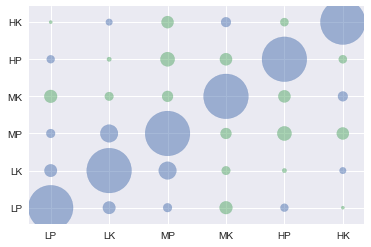

In [16]:
label = ('LP', 'LK', 'MP', 'MK', 'HP', 'HK')
x = range(1,7)
y = range(1,7)
xx, yy = np.meshgrid(x, y)
sb.set()
fig, ax = plt.subplots()
C = 2e3  # グラフ表示のための定数（見やすいように適当に決める）
#ax.scatter(xx, yy, s=abs(Sigma)*C, alpha=0.5)  # 本来はこれ
warnings.simplefilter('ignore', RuntimeWarning)
ax.scatter(xx, yy, s= Sigma*C, alpha=0.5)
ax.scatter(xx, yy, s=-Sigma*C, alpha=0.5)
plt.xticks(x, label)
plt.yticks(x, label)
plt.show()

前記の行列表示と上下逆になっていますが、円の面積が$\sigma$の大きさを表しています。また緑の部分は負の数値を表しています。コード中では、無理やりエラー抑制して、色を付けています（めんどくさかったので・・・）。

## まとめ
以上より、正規化した場合の共分散の最大値が0.15であって、1に比べてだいぶ小さいため、かなりの確かさで識別できそうだということがわかりました。次は実際に録音したゲーム音声で、識別可能性を確認します。